In [ ]:
!pip install tensorflow tensorrt keras

In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import re

In [3]:
# for inputing csv file as the data, skip this block if the dataframe is already loaded
df = pd.read_csv('./data/df_data_filter.csv')
df = df.drop(columns=['Unnamed: 0'])
wq = ['BOD', 'AmNi', 'wq', 'DO', 'Ecoli', 'FC', 'NitraNi', 'NitriNi', 'OrPh', 'pH', 'Sal', 'SDD', 'Si', 'SS', 'Temp', 'TIN', 'TKN', 'ToNi', 'ToPh', 'Tur', 'UnAm', 'VSS']

In [4]:
# Define train and test datasets

df_train = df[df['Image_Year'] <= 2019].drop(columns=['Image_Year']).copy()
df_test = df[df['Image_Year'] == 2020].drop(columns=['Image_Year']).copy()
X_train = df_train.drop(columns = wq)
X_test = df_test.drop(columns = wq)

std_scaler = StandardScaler()
std_scaler.set_output(transform='pandas')

# Transform the data (centering and scaling features)
df_train_scaled = std_scaler.fit_transform(df_train)
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.fit_transform(X_test)

df_scaled = std_scaler.fit_transform(df)

In [ ]:
df = pd.read_csv('./data/df_data_filter.csv')
df = df.drop(columns=['Unnamed: 0'])

# Assuming 'df' is your pandas DataFrame containing the time series data

print("Starting LSTM training...")

wq = ['Chla', 'SS', 'Tur']
n_splits = 5
seed = 1

LSTM_results = []

def create_model(input_shape, units=50, lr=0.001):
    model = Sequential()
    model.add(LSTM(units=units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

for wq_name in wq:
    print(f"\n{wq_name} Started")
    
    for first in range(4, 13):
        print(f"nvar {first}")
        print(f"Seed {seed}")
        
        # Define the TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=n_splits)

        for i, (train_index, test_index) in enumerate(tscv.split(df)):
            df_train, df_test = df.iloc[train_index], df.iloc[test_index]
            X_train, X_test = df_train.drop(columns=wq), df_test.drop(columns=wq)
            Y_train, Y_test = df_train[wq_name], df_test[wq_name]

            # Fit scaler on training data and transform both training and test data
            scaler_X = StandardScaler()
            scaler_Y = StandardScaler()
            X_train_scaled = scaler_X.fit_transform(X_train)
            X_test_scaled = scaler_X.transform(X_test)
            Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
            Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1)).flatten()

            print("\n--------------------------------------")
            print(f'Training split: {train_index[0]} to {train_index[-1]}, Testing split: {test_index[0]} to {test_index[-1]}')

            # Correlation-based feature selection
            c = df_train.corr().copy()
            c = c[wq_name][22:113]
            c = abs(c).sort_values(ascending=False)[0:first]
            var = c.index.tolist()

            X_train2 = X_train_scaled[:, [X_train.columns.get_loc(col) for col in var]]
            X_test2 = X_test_scaled[:, [X_test.columns.get_loc(col) for col in var]]

            # Reshape data for LSTM input
            X_train2 = X_train2.reshape((X_train2.shape[0], 1, X_train2.shape[1]))
            X_test2 = X_test2.reshape((X_test2.shape[0], 1, X_test2.shape[1]))

            # Create and fit the LSTM model
            model = create_model(input_shape=(X_train2.shape[1], X_train2.shape[2]), units=50, lr=0.001)
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            
            model.fit(X_train2, Y_train_scaled, validation_split=0.1, epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

            # Evaluate model on training data
            Y_train_pred_scaled = model.predict(X_train2)
            Y_train_pred_scaled[Y_train_pred_scaled < 0] = 0.0

            # Inverse transform the predictions and actual values
            Y_train_pred = scaler_Y.inverse_transform(Y_train_pred_scaled.reshape(-1, 1)).flatten()
            Y_train_unscaled = scaler_Y.inverse_transform(Y_train_scaled.reshape(-1, 1)).flatten()

            corr_model = np.corrcoef(Y_train_unscaled, Y_train_pred)[0, 1]
            rmse = mean_squared_error(Y_train_unscaled, Y_train_pred, squared=False)
            mae = mean_absolute_error(Y_train_unscaled, Y_train_pred)
            smape = np.mean(2 * (np.abs(Y_train_pred - Y_train_unscaled)) / (np.abs(Y_train_unscaled) + np.abs(Y_train_pred)))
            r_squared = 1 - (np.sum((Y_train_unscaled - Y_train_pred) ** 2) / np.sum((Y_train_unscaled - np.mean(Y_train_unscaled)) ** 2))
            adjusted_r_squared = 1 - (1 - r_squared) * (len(Y_train) - 1) / (len(Y_train) - X_train2.shape[2] - 1)

            print(f'{wq_name}: units: {50}, best_score: {r_squared}, RMSE: {rmse}')

            # Test model on testing data
            Y_test_pred_scaled = model.predict(X_test2)
            Y_test_pred_scaled[Y_test_pred_scaled < 0] = 0.0

            # Inverse transform the predictions and actual values
            Y_test_pred = scaler_Y.inverse_transform(Y_test_pred_scaled.reshape(-1, 1)).flatten()
            Y_test_unscaled = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1)).flatten()

            r_squared_test = 1 - (np.sum((Y_test_unscaled - Y_test_pred) ** 2) / np.sum((Y_test_unscaled - np.mean(Y_test_unscaled)) ** 2))
            corr_test = np.corrcoef(Y_test_unscaled, Y_test_pred)[0, 1]
            rmse_test = mean_squared_error(Y_test_unscaled, Y_test_pred, squared=False)
            mae_test = mean_absolute_error(Y_test_unscaled, Y_test_pred)
            smape_test = np.mean(2 * (np.abs(Y_test_pred - Y_test_unscaled)) / (np.abs(Y_test_unscaled) + np.abs(Y_test_pred)))
            print(f'{wq_name}: r_squared_test: {r_squared_test}, rmse_test: {rmse_test}, smape_test: {smape_test}')

            # Store results in a DataFrame
            LSTM_df = pd.DataFrame({
                'WQ': [wq_name], 'nvar': [first], 'var': [var], 'random_state': [seed],
                'units': [50], 'best_score': [r_squared],
                'r2': [r_squared], 'adjusted_r2': [adjusted_r_squared], 'corr_model': [corr_model],
                'rmse': [rmse], 'mae': [mae], 'smape': [smape],
                'r2_test': [r_squared_test], 'corr_test': [corr_test],
                'rmse_test': [rmse_test], 'mae_test': [mae_test], 'smape_test': [smape_test],
                'train_index': [train_index], 'test_index': [test_index],
                'Y_train': [Y_train], 'Y_train_pred': [Y_train_pred],
                'Y_test': [Y_test], 'Y_test_pred': [Y_test_pred]
            })

            LSTM_results.append(LSTM_df)
            print("--------------------------------------\n")

        print(f"{wq_name} Finished")

print("All LSTM training finished.")

# Combine all results into a single DataFrame
LSTM_result = pd.concat(LSTM_results, ignore_index=True)

# Save results to CSV
LSTM_result.to_csv("data/LSTM_results.csv", index=False)

print("Results saved to data/LSTM_results.csv")


# Optimal Models

In [4]:
df = pd.read_csv("data/LSTM_results.csv")

# Assuming df is your DataFrame
filtered_df = df[df['WQ'] == 'Tur']

lowest_rmse_entry = filtered_df.loc[filtered_df['rmse_test'].idxmin()]

print('Lowest rmse_test value:', lowest_rmse_entry['test_index'])
print('Other properties:', lowest_rmse_entry)


Lowest rmse_test value: [295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312
 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330
 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348
 349 350 351 352 353]
Other properties: WQ                                                            Tur
nvar                                                            9
var             ['LH_B4B5B6', 'LH_B5B6B7', 'B5_3', 'B5_2', 'LH...
random_state                                                    1
units                                                          50
best_score                                               0.398206
r2                                                       0.398206
adjusted_r2                                              0.379202
corr_model                                               0.661353
rmse                                                     3.849565
mae                                                      

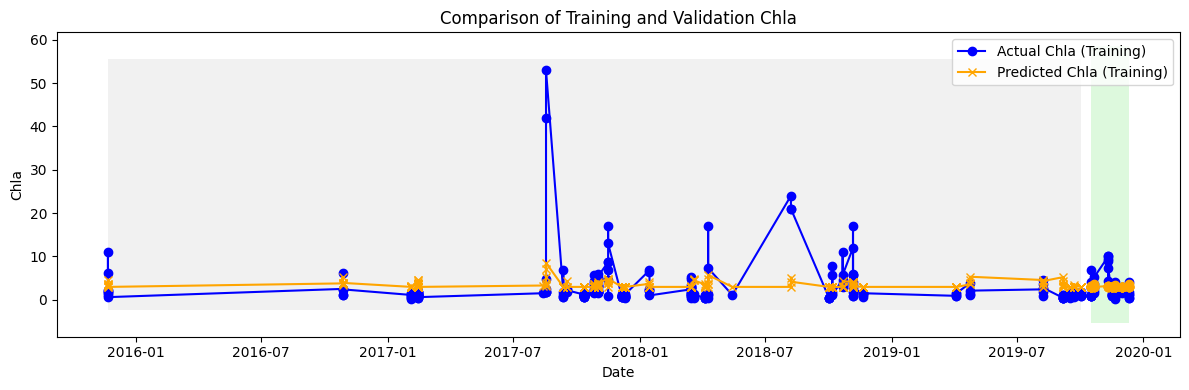

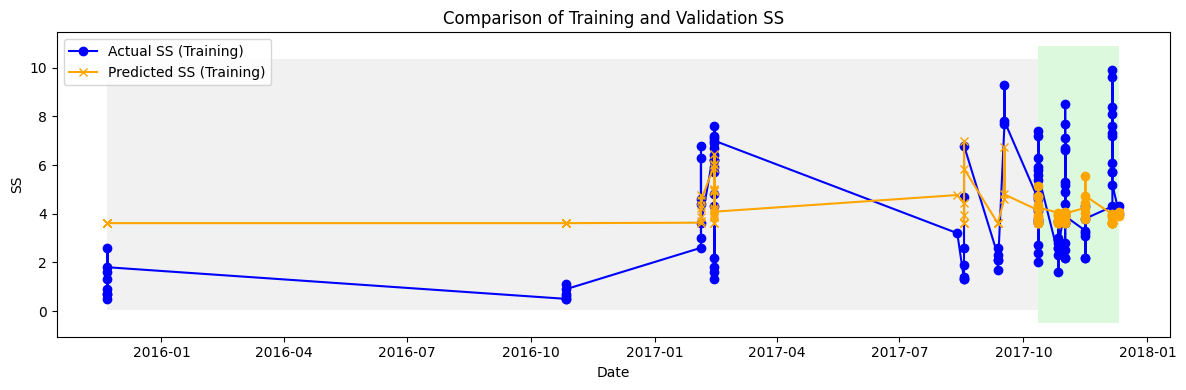

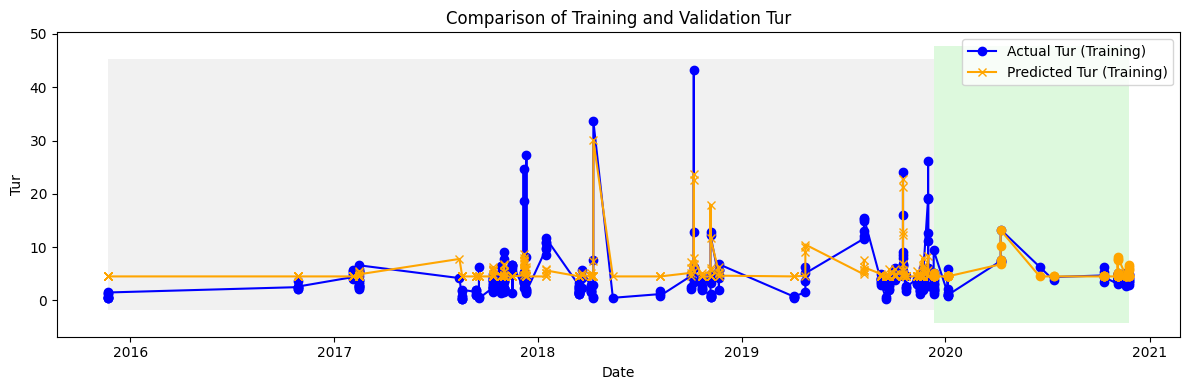

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def plot_wq_data_time_series(wq_name):
    # Load data
    df = pd.read_csv("data/LSTM_results.csv")
    filtered_df = df[df['WQ'] == wq_name]
    lowest_rmse_entry = filtered_df.loc[filtered_df['rmse_test'].idxmin()]

    # Load dates and corresponding values
    df_dates = pd.read_csv('./data/df_data_graphing_filter.csv')

    # Extract training data
    training_indexes = list(map(int, re.findall(r'\d+', lowest_rmse_entry['train_index'])))
    train_dates = pd.to_datetime(df_dates.loc[training_indexes[0]:training_indexes[-1], "Date"])
    train_values = df_dates.loc[training_indexes[0]:training_indexes[-1], wq_name]

    # Extract predicted values for training
    train_pred_str = lowest_rmse_entry["Y_train_pred"].replace('[', '').replace(']', '').replace('\n', '')
    train_pred_list_str = train_pred_str.split()
    train_pred_values = [float(num_str) for num_str in train_pred_list_str]

    # Extract testing data
    testing_indexes = list(map(int, re.findall(r'\d+', lowest_rmse_entry['test_index'])))
    test_dates = pd.to_datetime(df_dates.loc[testing_indexes[0]:testing_indexes[-1], "Date"])
    test_values = df_dates.loc[testing_indexes[0]:testing_indexes[-1], wq_name]

    # Extract predicted values for testing
    test_pred_str = lowest_rmse_entry["Y_test_pred"].replace('[', '').replace(']', '').replace('\n', '')
    test_pred_list_str = test_pred_str.split()
    test_pred_values = [float(num_str) for num_str in test_pred_list_str]

    # Create figure and axes
    fig, ax = plt.subplots(figsize=(12, 4))

    # Plot Training Data
    ax.plot(train_dates, train_values, label=f'Actual {wq_name} (Training)', marker='o', linestyle='-', color='blue')
    ax.plot(train_dates, train_pred_values, label=f'Predicted {wq_name} (Training)', marker='x', linestyle='-', color='orange')

    # Plot Validation Data
    ax.plot(test_dates, test_values, marker='o', linestyle='-', color='blue')
    ax.plot(test_dates, test_pred_values, marker='o', linestyle='-', color='orange')

    # Fill background colors
    ax.fill_between(train_dates, ax.get_ylim()[0], ax.get_ylim()[1], where=(train_dates >= min(train_dates)) & (train_dates <= max(train_dates)), facecolor='lightgrey', alpha=0.3, interpolate=True)
    ax.fill_between(test_dates, ax.get_ylim()[0], ax.get_ylim()[1], where=(test_dates >= min(test_dates)) & (test_dates <= max(test_dates)), facecolor='lightgreen', alpha=0.3, interpolate=True)

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel(wq_name)
    ax.set_title(f'Comparison of Training and Validation {wq_name}')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_wq_data_time_series('Chla')
plot_wq_data_time_series('SS')
plot_wq_data_time_series('Tur')

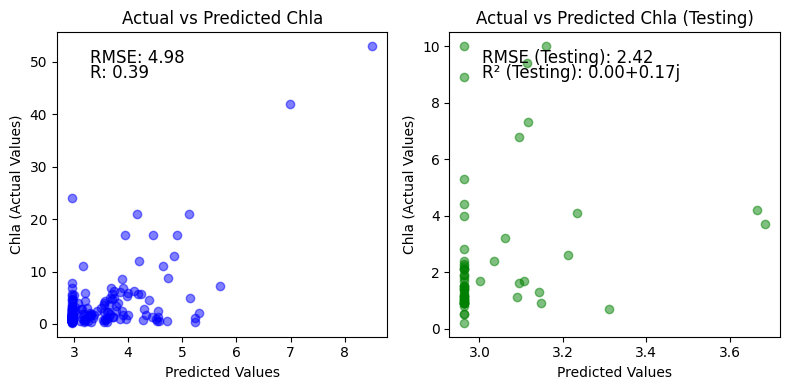

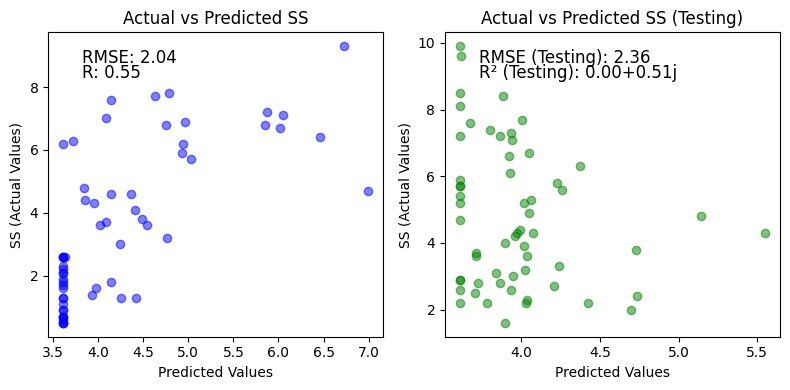

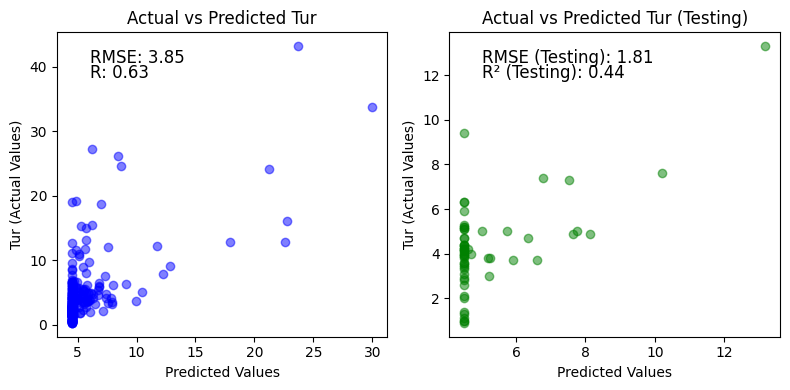

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def plot_wq_data(wq_name):
    # Load data
    df = pd.read_csv("data/LSTM/LSTM_results.csv")
    filtered_df = df[df['WQ'] == wq_name]
    lowest_rmse_entry = filtered_df.loc[filtered_df['rmse_test'].idxmin()]

    # Load dates and corresponding values
    df_dates = pd.read_csv('./data/df_data_graphing_filter.csv')

    # Extract training data
    training_indexes = list(map(int, re.findall(r'\d+', lowest_rmse_entry['train_index'])))
    train_values = df_dates.loc[training_indexes[0]:training_indexes[-1], wq_name]

    # Extract predicted values for training
    train_pred_str = lowest_rmse_entry["Y_train_pred"].replace('[', '').replace(']', '').replace('\n', '')
    train_pred_list_str = train_pred_str.split()
    train_pred_values = [float(num_str) for num_str in train_pred_list_str]
    
    # Extract testing data
    testing_indexes = list(map(int, re.findall(r'\d+', lowest_rmse_entry['test_index'])))
    test_values = df_dates.loc[testing_indexes[0]:testing_indexes[-1], wq_name]

    # Extract predicted values for testing
    test_pred_str = lowest_rmse_entry["Y_test_pred"].replace('[', '').replace(']', '').replace('\n', '')
    test_pred_list_str = test_pred_str.split()
    test_pred_values = [float(num_str) for num_str in test_pred_list_str]

    # Calculate RMSE and R from lowest_rmse_entry
    rmse = lowest_rmse_entry['rmse']
    r_value = float(lowest_rmse_entry['r2'])**.5
    
    # Calculate RMSE and R from lowest_rmse_entry for testing
    rmse_test = lowest_rmse_entry['rmse_test']
    r2_test = float(lowest_rmse_entry['r2_test'])**.5

    # Create figure and axes
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8, 4))


    # Plot Predicted vs Actual values
    ax.scatter(train_pred_values, train_values, color='blue', label='Actual vs Predicted', alpha=.5)
    
    # Add RMSE and R annotations
    ax.text(0.1, 0.9, f'RMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=12)
    ax.text(0.1, 0.85, f'R: {r_value:.2f}', transform=ax.transAxes, fontsize=12)

    # Set labels and title
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel(f'{wq_name} (Actual Values)')
    ax.set_title(f'Actual vs Predicted {wq_name}')
    
     # Plot Testing Data
    ax2.scatter(test_pred_values, test_values, color='green', alpha=0.5)
    ax2.text(0.1, 0.9, f'RMSE (Testing): {rmse_test:.2f}', transform=ax2.transAxes, fontsize=12)
    ax2.text(0.1, 0.85, f'R² (Testing): {r2_test:.2f}', transform=ax2.transAxes, fontsize=12)
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel(f'{wq_name} (Actual Values)')
    ax2.set_title(f'Actual vs Predicted {wq_name} (Testing)')


    plt.tight_layout()
    plt.show()

# Example usage:
plot_wq_data('Chla')
plot_wq_data('SS')
plot_wq_data('Tur')